In [1]:
import os
import torch
import torch.nn as nn


from config import get_config
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# cfg=get_config(config_path="config/swin_bs512_ep50_lr1e-04_ds1000.yml")
cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config()
print(cfg)

[INFO] Config Path: config/efficientnet_bs512_ep50_lr1e-04_ds1000.yml
[INFO] Detected WSL environment
[INFO] Using dataset root: /mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000
namespace(model_tag='EfficientNet', backbone='efficientnet', batch_size=512, epochs=50, learning_rate=0.0001, patience=50, input_shape=(1, 32, 32), global_max=121.79151153564453, dataset_root_dir='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled', train_csv='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/file_labels_aggregated_g1_train.csv', val_csv='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1


In [4]:
# Set seed, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
# torch.backends.cudnn.benchmark = True

[INFO] Using device: cuda


In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1
[INFO] Length of test dataloader: 1


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

MultiHeadClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (con

In [7]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [24]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [25]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] 🔁 Resuming training from checkpoint and summary
[INFO] Resumed at epoch 1 with total acc 0.0833 and early stop counter 0


In [26]:
print(all_epoch_metrics)
print(summary_status)
print(start_epoch)
print(best_epoch)

[{'epoch': 1, 'train_loss': 3.28476083278656, 'train_loss_energy': 0.6949081420898438, 'train_loss_alpha': 1.1585527062416077, 'train_loss_q0': 1.4312999844551086, 'train_acc': 0.04522613065326633, 'train_acc_energy': 0.2613065326633166, 'train_acc_alpha': 0.3015075376884422, 'train_acc_q0': 0.23869346733668342, 'val_loss': 3.1827118396759033, 'val_loss_energy': 0.6975798606872559, 'val_loss_alpha': 1.0986720323562622, 'val_loss_q0': 1.3864599466323853, 'val_acc': 0.08333333333333333, 'val_energy': {'accuracy': 0.25, 'precision': 0.125, 'recall': 0.5, 'f1': 0.2}, 'val_alpha': {'accuracy': 0.3333333333333333, 'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1': 0.16666666666666666}, 'val_q0': {'accuracy': 0.25, 'precision': 0.0625, 'recall': 0.25, 'f1': 0.1}}, {'epoch': 2, 'train_loss': 3.1882944107055664, 'train_loss_energy': 0.6829918622970581, 'train_loss_alpha': 1.1064431071281433, 'train_loss_q0': 1.3988593816757202, 'train_acc': 0.05150753768844221, 'train_acc_ener

In [27]:
def fill_trackers_from_history(all_epoch_metrics,
                               train_loss_energy_list, train_loss_alpha_list,
                               train_loss_q0_list, train_loss_list,
                               train_acc_energy_list, train_acc_alpha_list,
                               train_acc_q0_list, train_acc_list,
                               val_loss_energy_list, val_loss_alpha_list,
                               val_loss_q0_list, val_loss_list,
                               val_acc_energy_list, val_acc_alpha_list,
                               val_acc_q0_list, val_acc_list,
                               summary_status, best_epoch):
    """
    If summary_status indicates an interrupted/incomplete run,
    extract metrics from all_epoch_metrics and append into the provided lists.
    """
    if summary_status != "interrupted_or_incomplete":
        return

    # Trim metrics in-place
    trimmed = [r for r in all_epoch_metrics if r["epoch"] <= best_epoch]
    all_epoch_metrics[:] = trimmed

    for record in trimmed:
        # training
        train_loss_energy_list.append(record["train_loss_energy"])
        train_loss_alpha_list.append(record["train_loss_alpha"])
        train_loss_q0_list.append(record["train_loss_q0"])
        train_loss_list.append(record["train_loss"])
        train_acc_energy_list.append(record["train_acc_energy"])
        train_acc_alpha_list.append(record["train_acc_alpha"])
        train_acc_q0_list.append(record["train_acc_q0"])
        train_acc_list.append(record["train_acc"])

        # validation
        val_loss_energy_list.append(record["val_loss_energy"])
        val_loss_alpha_list.append(record["val_loss_alpha"])
        val_loss_q0_list.append(record["val_loss_q0"])
        val_loss_list.append(record["val_loss"])
        val_acc_energy_list.append(record["val_energy"]["accuracy"])
        val_acc_alpha_list.append(record["val_alpha"]["accuracy"])
        val_acc_q0_list.append(record["val_q0"]["accuracy"])
        val_acc_list.append(record["val_acc"])


In [28]:
print(train_acc_energy_list)

[]


In [29]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [30]:
print(train_acc_energy_list)
print(all_epoch_metrics)

[0.2613065326633166]
[{'epoch': 1, 'train_loss': 3.28476083278656, 'train_loss_energy': 0.6949081420898438, 'train_loss_alpha': 1.1585527062416077, 'train_loss_q0': 1.4312999844551086, 'train_acc': 0.04522613065326633, 'train_acc_energy': 0.2613065326633166, 'train_acc_alpha': 0.3015075376884422, 'train_acc_q0': 0.23869346733668342, 'val_loss': 3.1827118396759033, 'val_loss_energy': 0.6975798606872559, 'val_loss_alpha': 1.0986720323562622, 'val_loss_q0': 1.3864599466323853, 'val_acc': 0.08333333333333333, 'val_energy': {'accuracy': 0.25, 'precision': 0.125, 'recall': 0.5, 'f1': 0.2}, 'val_alpha': {'accuracy': 0.3333333333333333, 'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1': 0.16666666666666666}, 'val_q0': {'accuracy': 0.25, 'precision': 0.0625, 'recall': 0.25, 'f1': 0.1}}]


In [ ]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [31]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"[INFO] Epoch {epoch+1}/{cfg.epochs}")
    train_metrics={}
    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
    (train_loss_list,
    train_loss_energy_list,
    train_loss_alpha_list,
    train_loss_q0_list,
    train_acc_list,
    train_acc_energy_list,
    train_acc_alpha_list,
    train_acc_q0_list
    ) = update_train_logs(
        train_metrics,
        train_loss_list,
        train_loss_energy_list,
        train_loss_alpha_list,
        train_loss_q0_list,
        train_acc_list,
        train_acc_energy_list,
        train_acc_alpha_list,
        train_acc_q0_list
    )
    val_metrics = evaluate(val_loader, model, criterion, device)
    (val_loss_list,
    val_loss_energy_list,
    val_loss_alpha_list,
    val_loss_q0_list,
    val_acc_list,
    val_acc_energy_list,
    val_acc_alpha_list,
    val_acc_q0_list,
    ) = update_val_logs(
        val_metrics,
        val_loss_list,
        val_loss_energy_list,
        val_loss_alpha_list,
        val_loss_q0_list,
        val_acc_list,
        val_acc_energy_list,
        val_acc_alpha_list,
        val_acc_q0_list,
    )
    print(f"[INFO] Epoch {epoch+1}: Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
    print(f"[INFO] Epoch {epoch+1}: Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")
    
    all_epoch_metrics=record_and_save_epoch(epoch, train_metrics, val_metrics, all_epoch_metrics, cfg.output_dir)
    
    # save_epoch_checkpoint(
    #     epoch=epoch,
    #     model=model,
    #     optimizer=optimizer,
    #     metrics=val_metrics,
    #     output_dir=cfg.output_dir
    # )

    best_acc, best_metrics, best_epoch, early_stop_counter, should_stop = check_early_stopping(
        best_acc=best_acc,
        best_metrics=best_metrics,
        early_stop_counter=early_stop_counter,
        best_epoch=best_epoch,
        model=model,
        optimizer=optimizer,
        val_metrics=val_metrics,
        output_dir=cfg.output_dir,
        patience=cfg.patience,
        epoch=epoch
    )
    
    if should_stop:
        break
    
    print("="*150)
    

[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =0.2500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 2: Energy Loss =0.6959, αs Loss = 1.0987, Q0 Loss = 1.3865, Total Loss = 3.1811
[INFO] Epoch 2: Saving metrics to disk
⏳ No improvement. Early stop counter: 1/50
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =0.2500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 3: Energy Loss =0.6949, αs Loss = 1.0988, Q0 Loss = 1.3865, Total Loss = 3.1802
[INFO] Epoch 3: Saving metrics to disk
⏳ No improvement. Early stop counter: 2/50
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 4: Energy Loss =0.6926, αs Loss = 1.0990, Q0 Loss = 1.3865, Total Loss = 3.1781
[INFO] Epoch 4: Saving metrics to disk
⏳ No improvement. Early stop counter: 3/50
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 5: Energy Loss =0.6898, αs Loss = 1.0991, Q0 Loss = 1.3865, Total Loss = 3.1754
[INFO] Epoch 5: Saving metrics to disk
⏳ No improvement. Early stop counter: 4/50
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 6: Energy Loss =0.6871, αs Loss = 1.0992, Q0 Loss = 1.3865, Total Loss = 3.1727
[INFO] Epoch 6: Saving metrics to disk
⏳ No improvement. Early stop counter: 5/50
[INFO] Epoch 7/50


[INFO] Epoch 7: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 7: Energy Loss =0.6832, αs Loss = 1.0992, Q0 Loss = 1.3865, Total Loss = 3.1688
[INFO] Epoch 7: Saving metrics to disk
⏳ No improvement. Early stop counter: 6/50
[INFO] Epoch 8/50


[INFO] Epoch 8: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 8: Energy Loss =0.6788, αs Loss = 1.0991, Q0 Loss = 1.3865, Total Loss = 3.1644
[INFO] Epoch 8: Saving metrics to disk
⏳ No improvement. Early stop counter: 7/50
[INFO] Epoch 9/50


[INFO] Epoch 9: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 9: Energy Loss =0.6736, αs Loss = 1.0991, Q0 Loss = 1.3865, Total Loss = 3.1592
[INFO] Epoch 9: Saving metrics to disk
⏳ No improvement. Early stop counter: 8/50
[INFO] Epoch 10/50


[INFO] Epoch 10: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 10: Energy Loss =0.6684, αs Loss = 1.0991, Q0 Loss = 1.3865, Total Loss = 3.1540
[INFO] Epoch 10: Saving metrics to disk
⏳ No improvement. Early stop counter: 9/50
[INFO] Epoch 11/50


[INFO] Epoch 11: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 11: Energy Loss =0.6626, αs Loss = 1.0992, Q0 Loss = 1.3865, Total Loss = 3.1483
[INFO] Epoch 11: Saving metrics to disk
⏳ No improvement. Early stop counter: 10/50
[INFO] Epoch 12/50


[INFO] Epoch 12: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 12: Energy Loss =0.6571, αs Loss = 1.0993, Q0 Loss = 1.3865, Total Loss = 3.1430
[INFO] Epoch 12: Saving metrics to disk
⏳ No improvement. Early stop counter: 11/50
[INFO] Epoch 13/50


[INFO] Epoch 13: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 13: Energy Loss =0.6520, αs Loss = 1.0995, Q0 Loss = 1.3865, Total Loss = 3.1381
[INFO] Epoch 13: Saving metrics to disk
⏳ No improvement. Early stop counter: 12/50
[INFO] Epoch 14/50


[INFO] Epoch 14: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 14: Energy Loss =0.6468, αs Loss = 1.0998, Q0 Loss = 1.3866, Total Loss = 3.1331
[INFO] Epoch 14: Saving metrics to disk
⏳ No improvement. Early stop counter: 13/50
[INFO] Epoch 15/50


[INFO] Epoch 15: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 15: Energy Loss =0.6422, αs Loss = 1.1001, Q0 Loss = 1.3866, Total Loss = 3.1288
[INFO] Epoch 15: Saving metrics to disk
⏳ No improvement. Early stop counter: 14/50
[INFO] Epoch 16/50


[INFO] Epoch 16: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 16: Energy Loss =0.6374, αs Loss = 1.1003, Q0 Loss = 1.3866, Total Loss = 3.1243
[INFO] Epoch 16: Saving metrics to disk
⏳ No improvement. Early stop counter: 15/50
[INFO] Epoch 17/50


[INFO] Epoch 17: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 17: Energy Loss =0.6326, αs Loss = 1.1005, Q0 Loss = 1.3867, Total Loss = 3.1198
[INFO] Epoch 17: Saving metrics to disk
⏳ No improvement. Early stop counter: 16/50
[INFO] Epoch 18/50


[INFO] Epoch 18: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 18: Energy Loss =0.6281, αs Loss = 1.1006, Q0 Loss = 1.3867, Total Loss = 3.1154
[INFO] Epoch 18: Saving metrics to disk
⏳ No improvement. Early stop counter: 17/50
[INFO] Epoch 19/50


[INFO] Epoch 19: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 19: Energy Loss =0.6237, αs Loss = 1.1010, Q0 Loss = 1.3867, Total Loss = 3.1113
[INFO] Epoch 19: Saving metrics to disk
⏳ No improvement. Early stop counter: 18/50
[INFO] Epoch 20/50


[INFO] Epoch 20: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 20: Energy Loss =0.6202, αs Loss = 1.1011, Q0 Loss = 1.3867, Total Loss = 3.1079
[INFO] Epoch 20: Saving metrics to disk
⏳ No improvement. Early stop counter: 19/50
[INFO] Epoch 21/50


[INFO] Epoch 21: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 21: Energy Loss =0.6162, αs Loss = 1.1013, Q0 Loss = 1.3867, Total Loss = 3.1043
[INFO] Epoch 21: Saving metrics to disk
⏳ No improvement. Early stop counter: 20/50
[INFO] Epoch 22/50


[INFO] Epoch 22: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 22: Energy Loss =0.6130, αs Loss = 1.1015, Q0 Loss = 1.3867, Total Loss = 3.1012
[INFO] Epoch 22: Saving metrics to disk
⏳ No improvement. Early stop counter: 21/50
[INFO] Epoch 23/50


[INFO] Epoch 23: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 23: Energy Loss =0.6100, αs Loss = 1.1016, Q0 Loss = 1.3867, Total Loss = 3.0984
[INFO] Epoch 23: Saving metrics to disk
⏳ No improvement. Early stop counter: 22/50
[INFO] Epoch 24/50


[INFO] Epoch 24: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 24: Energy Loss =0.6063, αs Loss = 1.1018, Q0 Loss = 1.3867, Total Loss = 3.0948
[INFO] Epoch 24: Saving metrics to disk
⏳ No improvement. Early stop counter: 23/50
[INFO] Epoch 25/50


[INFO] Epoch 25: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 25: Energy Loss =0.6028, αs Loss = 1.1018, Q0 Loss = 1.3867, Total Loss = 3.0913
[INFO] Epoch 25: Saving metrics to disk
⏳ No improvement. Early stop counter: 24/50
[INFO] Epoch 26/50


[INFO] Epoch 26: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 26: Energy Loss =0.5992, αs Loss = 1.1017, Q0 Loss = 1.3868, Total Loss = 3.0877
[INFO] Epoch 26: Saving metrics to disk
⏳ No improvement. Early stop counter: 25/50
[INFO] Epoch 27/50


[INFO] Epoch 27: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 27: Energy Loss =0.5953, αs Loss = 1.1016, Q0 Loss = 1.3870, Total Loss = 3.0839
[INFO] Epoch 27: Saving metrics to disk
⏳ No improvement. Early stop counter: 26/50
[INFO] Epoch 28/50


[INFO] Epoch 28: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 28: Energy Loss =0.5916, αs Loss = 1.1016, Q0 Loss = 1.3873, Total Loss = 3.0805
[INFO] Epoch 28: Saving metrics to disk
⏳ No improvement. Early stop counter: 27/50
[INFO] Epoch 29/50


[INFO] Epoch 29: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 29: Energy Loss =0.5882, αs Loss = 1.1017, Q0 Loss = 1.3875, Total Loss = 3.0774
[INFO] Epoch 29: Saving metrics to disk
⏳ No improvement. Early stop counter: 28/50
[INFO] Epoch 30/50


[INFO] Epoch 30: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 30: Energy Loss =0.5850, αs Loss = 1.1018, Q0 Loss = 1.3878, Total Loss = 3.0747
[INFO] Epoch 30: Saving metrics to disk
⏳ No improvement. Early stop counter: 29/50
[INFO] Epoch 31/50


[INFO] Epoch 31: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 31: Energy Loss =0.5819, αs Loss = 1.1019, Q0 Loss = 1.3881, Total Loss = 3.0719
[INFO] Epoch 31: Saving metrics to disk
⏳ No improvement. Early stop counter: 30/50
[INFO] Epoch 32/50


[INFO] Epoch 32: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 32: Energy Loss =0.5790, αs Loss = 1.1021, Q0 Loss = 1.3886, Total Loss = 3.0696
[INFO] Epoch 32: Saving metrics to disk
⏳ No improvement. Early stop counter: 31/50
[INFO] Epoch 33/50


[INFO] Epoch 33: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 33: Energy Loss =0.5767, αs Loss = 1.1021, Q0 Loss = 1.3890, Total Loss = 3.0678
[INFO] Epoch 33: Saving metrics to disk
⏳ No improvement. Early stop counter: 32/50
[INFO] Epoch 34/50


[INFO] Epoch 34: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 34: Energy Loss =0.5748, αs Loss = 1.1021, Q0 Loss = 1.3895, Total Loss = 3.0664
[INFO] Epoch 34: Saving metrics to disk
⏳ No improvement. Early stop counter: 33/50
[INFO] Epoch 35/50


[INFO] Epoch 35: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 35: Energy Loss =0.5732, αs Loss = 1.1023, Q0 Loss = 1.3898, Total Loss = 3.0654
[INFO] Epoch 35: Saving metrics to disk
⏳ No improvement. Early stop counter: 34/50
[INFO] Epoch 36/50


[INFO] Epoch 36: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 36: Energy Loss =0.5715, αs Loss = 1.1025, Q0 Loss = 1.3901, Total Loss = 3.0641
[INFO] Epoch 36: Saving metrics to disk
⏳ No improvement. Early stop counter: 35/50
[INFO] Epoch 37/50


[INFO] Epoch 37: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 37: Energy Loss =0.5699, αs Loss = 1.1031, Q0 Loss = 1.3901, Total Loss = 3.0631
[INFO] Epoch 37: Saving metrics to disk
⏳ No improvement. Early stop counter: 36/50
[INFO] Epoch 38/50


[INFO] Epoch 38: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 38: Energy Loss =0.5683, αs Loss = 1.1037, Q0 Loss = 1.3900, Total Loss = 3.0619
[INFO] Epoch 38: Saving metrics to disk
⏳ No improvement. Early stop counter: 37/50
[INFO] Epoch 39/50


[INFO] Epoch 39: Energy Acc =0.7500, αs Acc = 0.3438, Q0 Acc = 0.2604, Total Acc = 0.0938
[INFO] Epoch 39: Energy Loss =0.5668, αs Loss = 1.1046, Q0 Loss = 1.3895, Total Loss = 3.0608
[INFO] Epoch 39: Saving metrics to disk
✅ Best model saved at epoch 39 with total accuracy: 0.0938
[INFO] Epoch 40/50


[INFO] Epoch 40: Energy Acc =0.7500, αs Acc = 0.3438, Q0 Acc = 0.2708, Total Acc = 0.1042
[INFO] Epoch 40: Energy Loss =0.5652, αs Loss = 1.1056, Q0 Loss = 1.3884, Total Loss = 3.0592
[INFO] Epoch 40: Saving metrics to disk
✅ Best model saved at epoch 40 with total accuracy: 0.1042
[INFO] Epoch 41/50


[INFO] Epoch 41: Energy Acc =0.7500, αs Acc = 0.3438, Q0 Acc = 0.2812, Total Acc = 0.1042
[INFO] Epoch 41: Energy Loss =0.5629, αs Loss = 1.1072, Q0 Loss = 1.3873, Total Loss = 3.0575
[INFO] Epoch 41: Saving metrics to disk
⏳ No improvement. Early stop counter: 1/50
[INFO] Epoch 42/50


[INFO] Epoch 42: Energy Acc =0.7500, αs Acc = 0.3438, Q0 Acc = 0.2812, Total Acc = 0.1042
[INFO] Epoch 42: Energy Loss =0.5595, αs Loss = 1.1096, Q0 Loss = 1.3859, Total Loss = 3.0550
[INFO] Epoch 42: Saving metrics to disk
⏳ No improvement. Early stop counter: 2/50
[INFO] Epoch 43/50


[INFO] Epoch 43: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2917, Total Acc = 0.1042
[INFO] Epoch 43: Energy Loss =0.5548, αs Loss = 1.1135, Q0 Loss = 1.3825, Total Loss = 3.0508
[INFO] Epoch 43: Saving metrics to disk
⏳ No improvement. Early stop counter: 3/50
[INFO] Epoch 44/50


[INFO] Epoch 44: Energy Acc =0.7604, αs Acc = 0.3333, Q0 Acc = 0.2604, Total Acc = 0.0938
[INFO] Epoch 44: Energy Loss =0.5491, αs Loss = 1.1174, Q0 Loss = 1.3788, Total Loss = 3.0453
[INFO] Epoch 44: Saving metrics to disk
⏳ No improvement. Early stop counter: 4/50
[INFO] Epoch 45/50


[INFO] Epoch 45: Energy Acc =0.7604, αs Acc = 0.3333, Q0 Acc = 0.2396, Total Acc = 0.0729
[INFO] Epoch 45: Energy Loss =0.5441, αs Loss = 1.1224, Q0 Loss = 1.3755, Total Loss = 3.0420
[INFO] Epoch 45: Saving metrics to disk
⏳ No improvement. Early stop counter: 5/50
[INFO] Epoch 46/50


[INFO] Epoch 46: Energy Acc =0.7604, αs Acc = 0.3229, Q0 Acc = 0.2292, Total Acc = 0.0729
[INFO] Epoch 46: Energy Loss =0.5378, αs Loss = 1.1288, Q0 Loss = 1.3736, Total Loss = 3.0402
[INFO] Epoch 46: Saving metrics to disk
⏳ No improvement. Early stop counter: 6/50
[INFO] Epoch 47/50


[INFO] Epoch 47: Energy Acc =0.7604, αs Acc = 0.2917, Q0 Acc = 0.2396, Total Acc = 0.0729
[INFO] Epoch 47: Energy Loss =0.5326, αs Loss = 1.1354, Q0 Loss = 1.3731, Total Loss = 3.0411
[INFO] Epoch 47: Saving metrics to disk
⏳ No improvement. Early stop counter: 7/50
[INFO] Epoch 48/50


[INFO] Epoch 48: Energy Acc =0.7604, αs Acc = 0.2708, Q0 Acc = 0.2292, Total Acc = 0.0521
[INFO] Epoch 48: Energy Loss =0.5299, αs Loss = 1.1408, Q0 Loss = 1.3780, Total Loss = 3.0488
[INFO] Epoch 48: Saving metrics to disk
⏳ No improvement. Early stop counter: 8/50
[INFO] Epoch 49/50


[INFO] Epoch 49: Energy Acc =0.7604, αs Acc = 0.2812, Q0 Acc = 0.2604, Total Acc = 0.0208
[INFO] Epoch 49: Energy Loss =0.5323, αs Loss = 1.1518, Q0 Loss = 1.3890, Total Loss = 3.0730
[INFO] Epoch 49: Saving metrics to disk
⏳ No improvement. Early stop counter: 9/50
[INFO] Epoch 50/50


[INFO] Epoch 50: Energy Acc =0.7708, αs Acc = 0.3021, Q0 Acc = 0.2708, Total Acc = 0.0208
[INFO] Epoch 50: Energy Loss =0.5372, αs Loss = 1.1637, Q0 Loss = 1.4031, Total Loss = 3.1040
[INFO] Epoch 50: Saving metrics to disk
⏳ No improvement. Early stop counter: 10/50


In [32]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1/training_summary.json

🏁 Best Model @ Epoch 40
Total Accuracy: 0.1042

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3438
  Precision: 0.6111
  Recall   : 0.3438
  F1-Score : 0.2051

🔹 Q0 Task
  Accuracy : 0.2708
  Precision: 0.3993
  Recall   : 0.2708
  F1-Score : 0.1429


📊 Plots saved to:
 - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1/loss_accuracy_plot.png
 - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1/loss_accuracy_plot.pdf


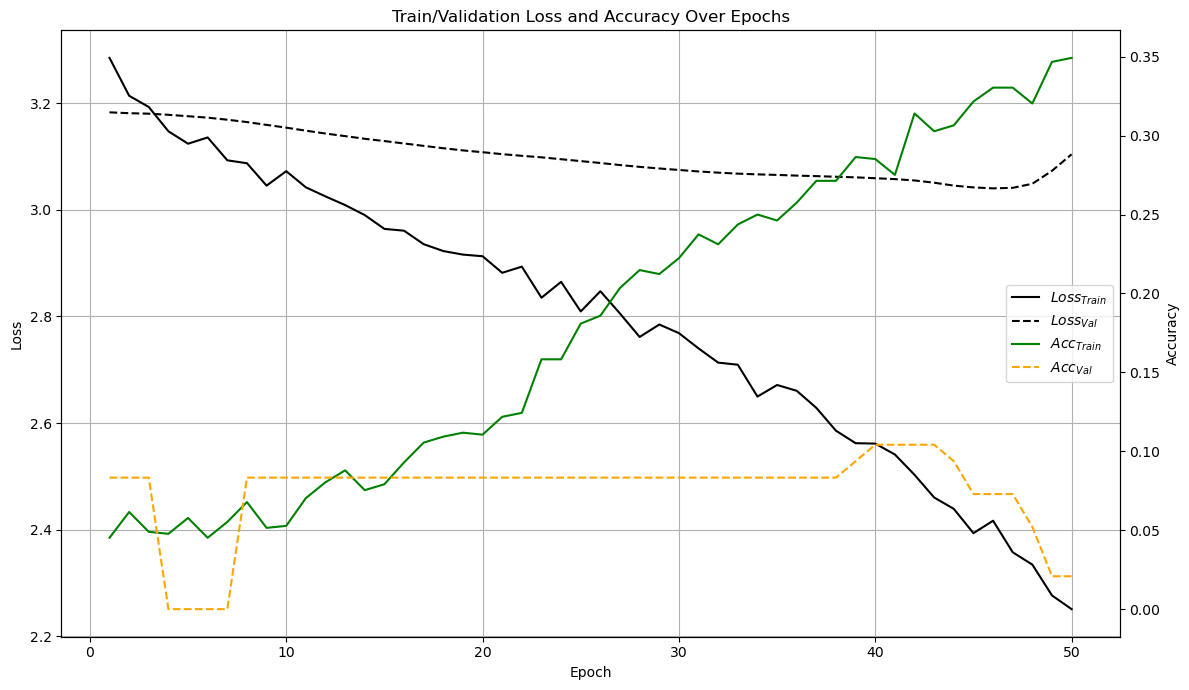

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1/train_loss_and_accuracy_per_epoch_plot.pdf


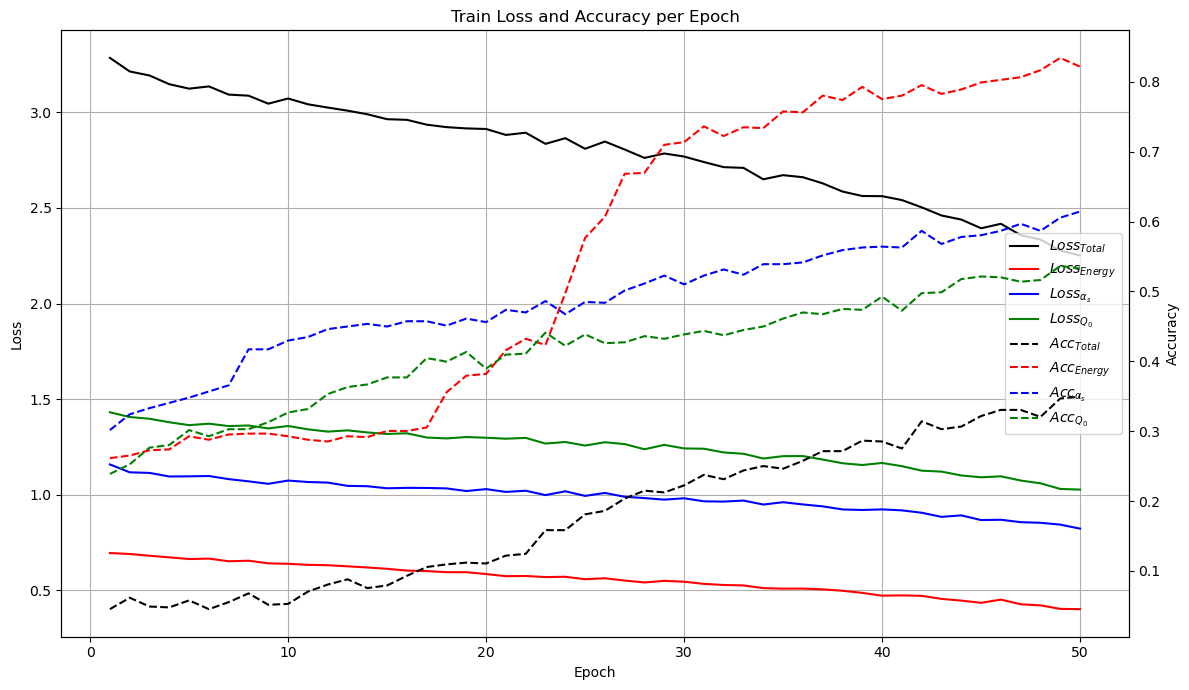

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000_g1/validation_loss_and_accuracy_per_epoch_plot.pdf


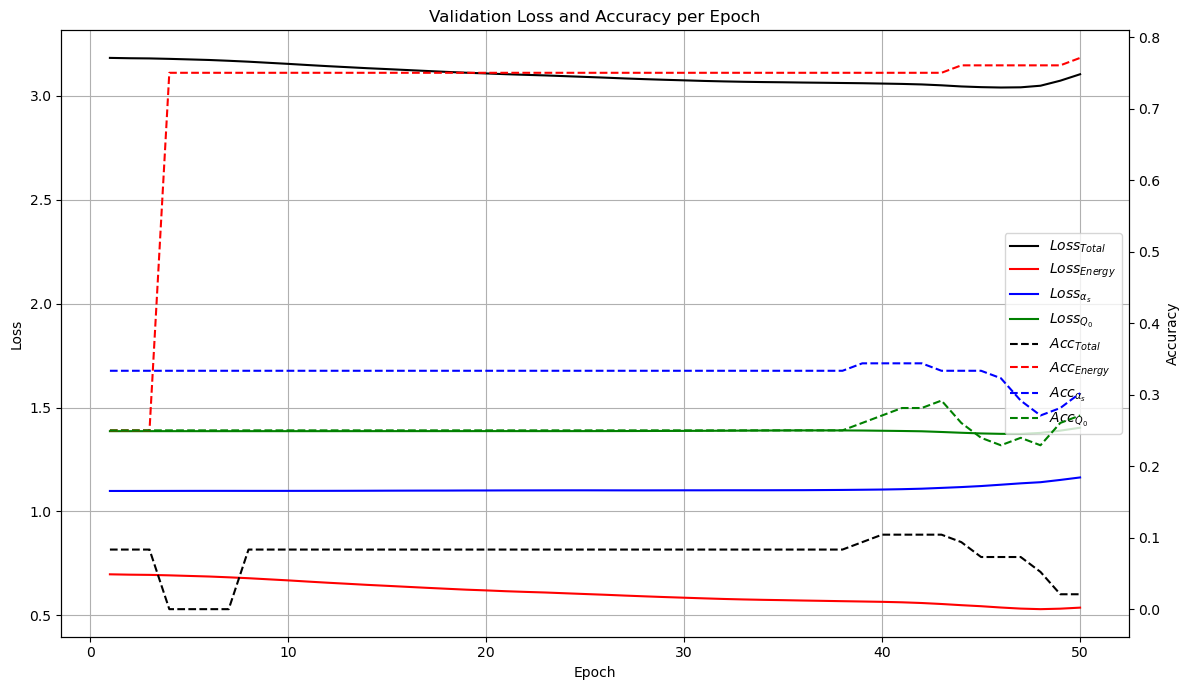

In [33]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")